# Preparamos los Datos Descargados de DatasetNinja

Este enlace tiene el dataset completo a diferencia de los otros enlaces de descargas que no tenían los datos de Noruega. Tenemos que modificar un poco el procesamiento de los datos, ya que las anotaciones vienen en JSONs y no XML.

Link de descarga: https://datasetninja.com/road-damage-detector#download

In [42]:
import os, sys
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [37]:
# Definimos el path de los datos
PATH = 'rdd2022-DatasetNinja'

# Si no existen all_train y all_test, renombramos las carpetas de train y test
if not os.path.exists(os.path.join(PATH, 'all_train')):
    os.rename(os.path.join(PATH, 'train'), os.path.join(PATH, 'all_train'))
    os.rename(os.path.join(PATH, 'test'), os.path.join(PATH, 'all_test'))
TRAIN_PATH = os.path.join(PATH, 'all_train')
TEST_PATH = os.path.join(PATH, 'all_test')

# Definimos las regiones
REGIONS = ['China_Drone', 'China_MotorBike', 'Czech', 'India', 'Japan', 'Norway', 'United_States']

# Definimos el numero de cojuntos para la validacion cruzada
NUM_FOLDS = 4

## Procesamos los datos de DatasetNinja

In [26]:
# Las carpetas de train y test contienen subcarpetas ann, img y meta.
# ann contiene los archivos .json con las anotaciones que tendremos que pasar al formato de YOLO. Es decir, un .txt con el mismo nombre que la imagen, pero donde cada objeto tiene una fila con el formato normalizado: <clase> <x_center> <y_center> <width> <height>
# img contiene las imágenes en formato .jpg
# meta contiene los archivos .json con información adicional de las imágenes, como las dimensiones de la imagen. Pero parecen estar todos vacíos, así que la vamos a borrar.
# Finalmente, vamos a separar las imágenes y labels en subcarpetas por región. De modo que tendremos una carpeta por región con una carpeta de train y otra de test, y dentro de cada una de ellas las imágenes y labels correspondientes.

# Borramos las carpetas de región si ya existen
for region in REGIONS:
    os.system(f'rm -rf {os.path.join(PATH, region)}')

# Creamos una carpeta por región
for region in REGIONS:
    os.makedirs(os.path.join(PATH, region, 'train'), exist_ok=True)
    os.makedirs(os.path.join(PATH, region, 'test'), exist_ok=True)
    # Para cada region, creamos una carpeta de train y otra de test. La carpeta de train con images y labels, y la de test solo con images
    os.makedirs(os.path.join(PATH, region, 'train', 'images'), exist_ok=True)
    os.makedirs(os.path.join(PATH, region, 'train', 'labels'), exist_ok=True)
    os.makedirs(os.path.join(PATH, region, 'test', 'images'), exist_ok=True)

# Transformamos las anotaciones a YOLO en train y test (Solo nos interesan las clases de la competición)
# Diccionarios para mapear de IDs del JSON a IDs de nuestros modelos
class_dict = {
    6511999: 0, # D00 - Longitudinal Crack
    6512000: 1, # D10 - Transverse Crack
    6512001: 2, # D20 - Alligator Crack
    6512002: 3, # D40 - Potholes
}

# Procesamos las anotaciones e imagenes de train
train_annotation_path = os.path.join(TRAIN_PATH, 'ann')
print('Transforming train annotations to YOLO format...')
for file in tqdm(os.listdir(train_annotation_path)):
    # For each JSON file, we read the data and write the YOLO format to a .txt file with the same name
    with open(os.path.join(train_annotation_path, file), 'r') as f:
        ann = json.load(f)
    # Nombre de la imagen
    file_name = file.split('.')[0]
    # Compronamos la región
    region = ann['tags'][0]['name']
    if region == 'United States': region = 'United_States'
    if region not in REGIONS:
        continue
    # Obtenemos las dimensiones de la imagen
    width = ann['size']['width']
    height = ann['size']['height']
    # Escribimos las anotaciones en el archivo .txt con el formato YOLO
    with open(os.path.join(PATH, region, 'train', 'labels', file_name + '.txt'), 'w') as f:
        for obj in ann['objects']:
            class_id = obj['classId']
            if class_id not in class_dict.keys():
                continue
            class_id = class_dict[class_id]
            x_center = (obj['points']['exterior'][0][0] + obj['points']['exterior'][1][0]) / 2 / width
            y_center = (obj['points']['exterior'][0][1] + obj['points']['exterior'][1][1]) / 2 / height
            width_obj = abs(obj['points']['exterior'][0][0] - obj['points']['exterior'][1][0]) / width
            height_obj = abs(obj['points']['exterior'][0][1] - obj['points']['exterior'][1][1]) / height
            f.write(f'{class_id} {x_center} {y_center} {width_obj} {height_obj}\n')
    # Copiamos la imagen
    os.system(f'cp {os.path.join(TRAIN_PATH, "img", file_name + ".jpg")} {os.path.join(PATH, region, "train", "images", file_name + ".jpg")}')

# Copiamos las imágenes de test a sus respectivas carpetas
print('Copying test images...')
for file in tqdm(os.listdir(os.path.join(TEST_PATH, 'img'))):
    # El nombre de las imagenes sigue el formato {region}_{id}.jpg
    region = None
    for reg in REGIONS:
        if reg in file:
            region = reg
            break
    if region is None:
        continue
    os.system(f'cp {os.path.join(TEST_PATH, "img", file)} {os.path.join(PATH, region, "test", "images", file)}')


Transforming train annotations to YOLO format...


100%|██████████| 38385/38385 [02:54<00:00, 219.40it/s]


Copying test images...


100%|██████████| 9035/9035 [00:32<00:00, 274.93it/s]


## Comprobamos que los datos de ambos orígenes sean iguales

Esto lo hacemos principalmente por no perder imágenes que serían útiles para el entrenamiento del modelo.

In [35]:
def compare_sets(set1, set2):
    # Comprueba si dos conjuntos de imágenes son iguales
    set1 = sorted(set1)
    set2 = sorted(set2)
    if len(set1) != len(set2):
        return False
    for i in range(len(set1)):
        if set1[i] != set2[i]:
            return False
    return True

# Comprobamos que tenemos las mismas imagenes en los dos conjuntos de datos descargados de distintas fuentes
ninja_path = 'rdd2022-DatasetNinja'
original_path = '../datasets/RDD2022/images'
original_test_path = 'RDD2022/images'

# Comprobamos que todos estos paths existen
assert os.path.exists(ninja_path), f'No se ha encontrado la carpeta {ninja_path}'
assert os.path.exists(original_path), f'No se ha encontrado la carpeta {original_path}'
assert os.path.exists(original_test_path), f'No se ha encontrado la carpeta {original_test_path}'

# Definimos las regiones que vamos a comparar
shared_regions = [region for region in REGIONS if region != 'Norway']

# Comprobamos que las imágenes de train y test de las regiones compartidas son las mismas
for region in shared_regions:
    ninja_train_images = os.listdir(os.path.join(ninja_path, region, 'train', 'images'))
    original_train_images = os.listdir(os.path.join(original_path, region, 'train', 'images'))
    assert compare_sets(set(ninja_train_images), set(original_train_images)), f'Las imágenes de train de la región {region} no coinciden.'

    # China_Drone no tiene imágenes de test
    if region != 'China_Drone': 
        ninja_test_images = os.listdir(os.path.join(ninja_path, region, 'test', 'images'))
        original_test_images = os.listdir(os.path.join(original_test_path, region, 'test', 'images'))
        assert compare_sets(ninja_test_images, original_test_images), f'Las imágenes de test de la región {region} no coinciden.'


# Comprobamos que las anotaciones son las mismas para las imágenes de train
for region in shared_regions:
    ninja_train_labels = os.listdir(os.path.join(ninja_path, region, 'train', 'labels'))
    original_train_labels = os.listdir(os.path.join(original_path, region, 'train', 'labels'))
    assert compare_sets(ninja_train_labels, original_train_labels), f'Las anotaciones de train de la región {region} no coinciden'

print('Las imágenes y anotaciones de train y test coinciden en las regiones compartidas')


# Comprobamos el numero de objetos anotados en total en ambos datasets
ninja_total_objects = 0
original_total_objects = 0

print('\nContando objetos anotados en los datasets...')
for region in tqdm(shared_regions):
    ninja_train_labels = os.listdir(os.path.join(ninja_path, region, 'train', 'labels'))
    original_train_labels = os.listdir(os.path.join(original_path, region, 'train', 'labels'))
    for label in ninja_train_labels:
        with open(os.path.join(ninja_path, region, 'train', 'labels', label), 'r') as f:
            ninja_total_objects += len(f.readlines())
    for label in original_train_labels:
        with open(os.path.join(original_path, region, 'train', 'labels', label), 'r') as f:
            original_total_objects += len(f.readlines())

print(f'Número total de objetos anotados en el dataset original: {original_total_objects}')
print(f'Número total de objetos anotados en el dataset ninja: {ninja_total_objects}')

Las imágenes y anotaciones de train y test coinciden en las regiones compartidas

Contando objetos anotados en los datasets...


100%|██████████| 6/6 [00:04<00:00,  1.49it/s]

Número total de objetos anotados en el dataset original: 43779
Número total de objetos anotados en el dataset ninja: 44003


## Preparamos la validación cruzada de los datos

La idea es que cada región divida sus datos de train en 4 partes, y que cada parte tenga su propia carpeta con las imágenes y sus anotaciones. De esta forma podemos crear ficheros yaml que utilicen estas carpetas para entrenar el modelo. Además, queremos barajar los datos para que no haya sesgo en el entrenamiento y que todos los conjuntos de datos tengan una distribución de imágenes similar.

In [38]:
# Para cada región, en la carpeta de train, cogemos las imágenes, las barajamos y las dividimos en 4 folds
# Para cada fold, creamos una carpeta con las imágenes y las labels
# En los ficheros yaml nos encargaremos de definir las iteraciones de entrenamiento y validación para hacer la validación cruzada

print('Creando folds para la validación cruzada...')
for region in tqdm(REGIONS):
    # Lista de imágenes de train
    images = os.listdir(os.path.join(PATH, region, 'train', 'images'))
    # Barajamos las imágenes
    np.random.shuffle(images)
    # Dividimos las imágenes en 4 folds
    folds = np.array_split(images, NUM_FOLDS)
    # Creamos las carpetas de los folds
    for i, fold in enumerate(folds):
        os.makedirs(os.path.join(PATH, region, 'train', f'fold_{i}'), exist_ok=True)
        os.makedirs(os.path.join(PATH, region, 'train', f'fold_{i}', 'images'), exist_ok=True)
        os.makedirs(os.path.join(PATH, region, 'train', f'fold_{i}', 'labels'), exist_ok=True)
        # Copiamos las imágenes y labels en las carpetas de los folds
        for img in fold:
            os.system(f'cp {os.path.join(PATH, region, "train", "images", img)} {os.path.join(PATH, region, "train", f"fold_{i}", "images", img)}')
            os.system(f'cp {os.path.join(PATH, region, "train", "labels", img.split(".")[0] + ".txt")} {os.path.join(PATH, region, "train", f"fold_{i}", "labels", img.split(".")[0] + ".txt")}')
    # Borramos las imágenes de train
    os.system(f'rm -rf {os.path.join(PATH, region, "train", "images")}')
    os.system(f'rm -rf {os.path.join(PATH, region, "train", "labels")}')

## Distribución de los datos

Algunos datos y gráficos sobre la distribución de los datos.

{'Japan': 10506, 'Norway': 8161, 'India': 7706, 'United_States': 4805, 'Czech': 2829, 'China_Drone': 2401, 'China_MotorBike': 1977}


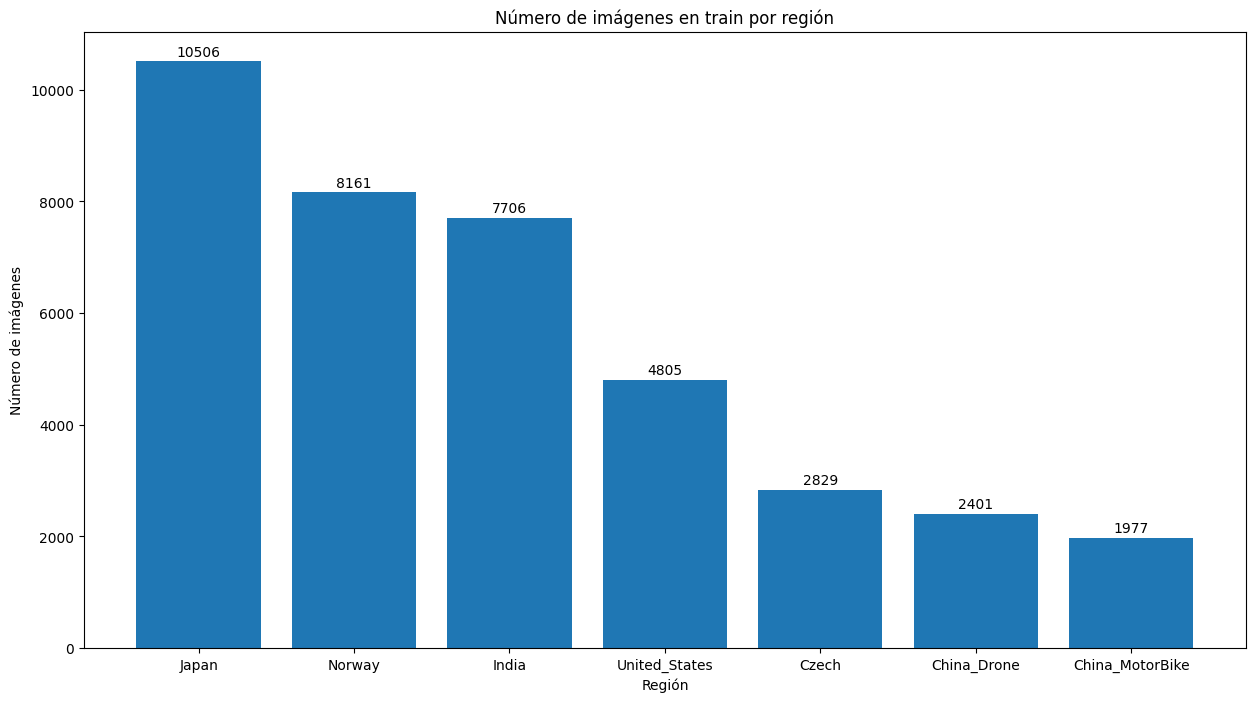

{'Japan': 2627, 'Norway': 2040, 'India': 1959, 'United_States': 1200, 'Czech': 709, 'China_MotorBike': 500, 'China_Drone': 0}


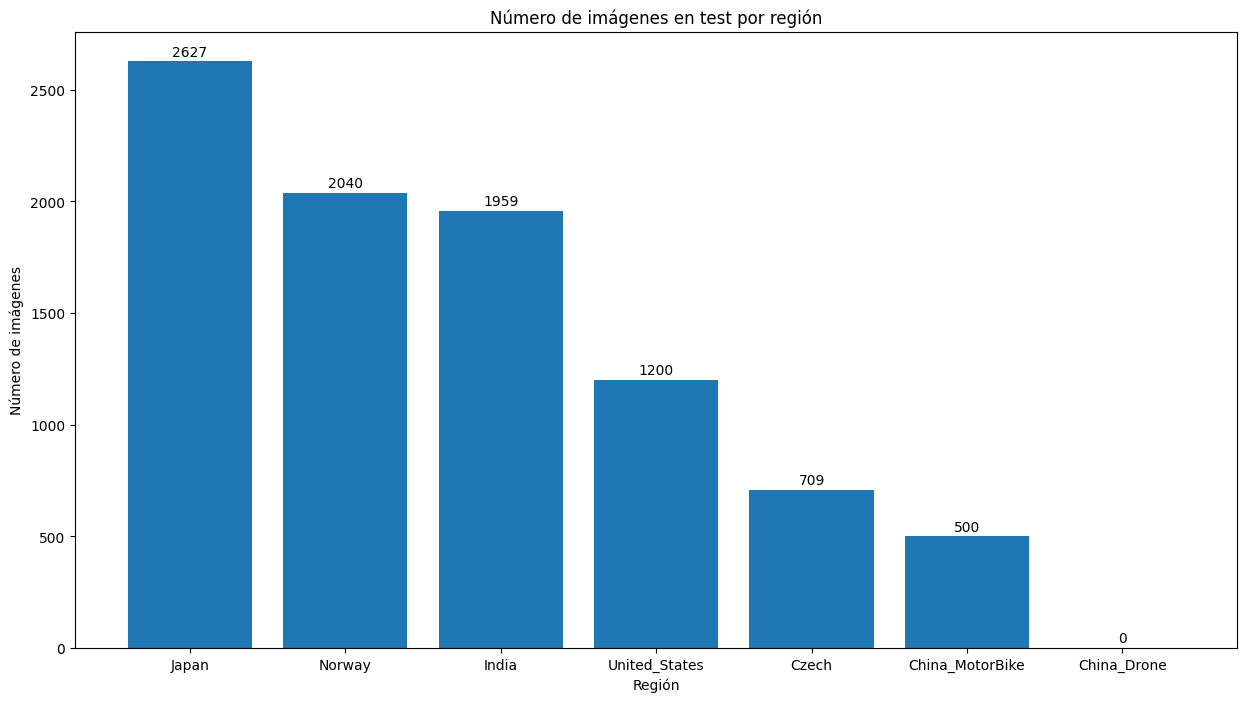

{'Japan': {'fold_0': 2627, 'total': 10506, 'fold_1': 2627, 'fold_2': 2626, 'fold_3': 2626}, 'Norway': {'fold_0': 2041, 'total': 8161, 'fold_1': 2040, 'fold_2': 2040, 'fold_3': 2040}, 'India': {'fold_0': 1927, 'total': 7706, 'fold_1': 1927, 'fold_2': 1926, 'fold_3': 1926}, 'United_States': {'fold_0': 1202, 'total': 4805, 'fold_1': 1201, 'fold_2': 1201, 'fold_3': 1201}, 'Czech': {'fold_0': 708, 'total': 2829, 'fold_1': 707, 'fold_2': 707, 'fold_3': 707}, 'China_Drone': {'fold_0': 601, 'total': 2401, 'fold_1': 600, 'fold_2': 600, 'fold_3': 600}, 'China_MotorBike': {'fold_0': 495, 'total': 1977, 'fold_1': 494, 'fold_2': 494, 'fold_3': 494}}


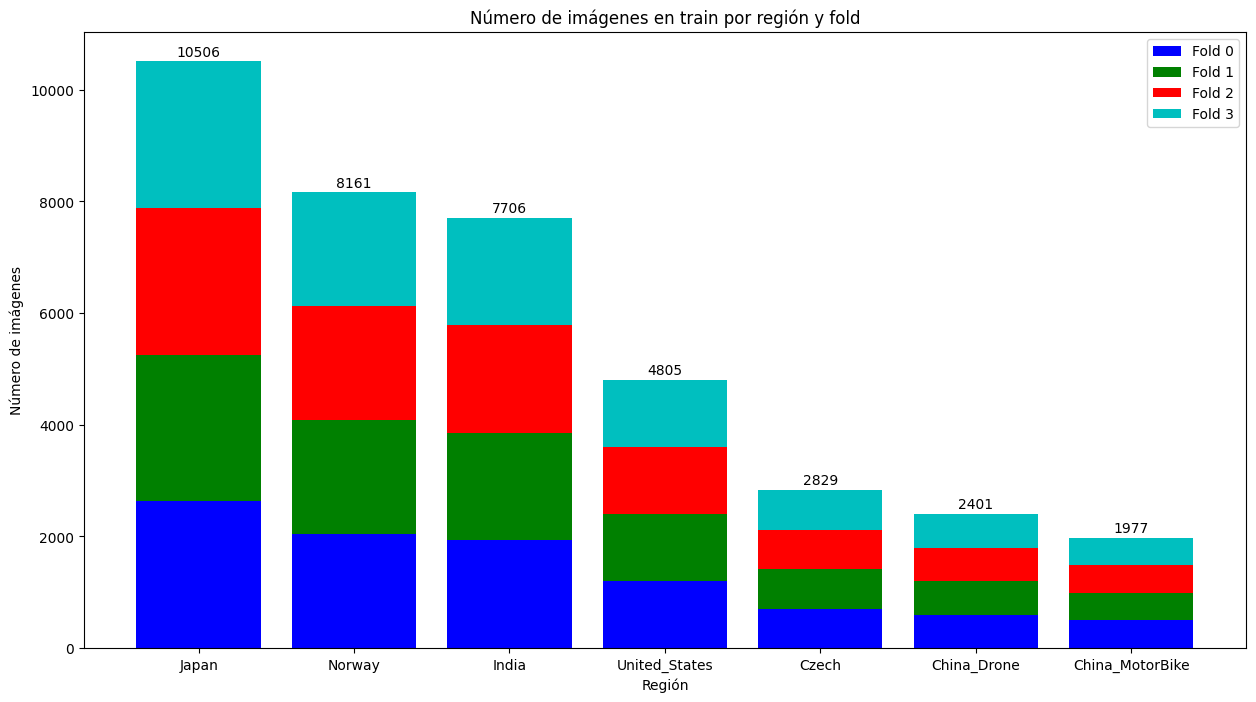

In [68]:
# Bar plot con el número de imágenes en train por cada regíon (repetir gráfico para train mostrando el número de imágenes en cada fold y para test mostrando el número de imágenes en cada región)
train_images_per_region = {}
for region in REGIONS:
    for fold in range(NUM_FOLDS):
        train_images_per_region[f'{region}'] = train_images_per_region.get(f'{region}', 0) + len(os.listdir(os.path.join(PATH, region, 'train', f'fold_{fold}', 'images')))
# Sort dictionary by values
train_images_per_region = dict(sorted(train_images_per_region.items(), key=lambda item: item[1], reverse=True))
# Mostramos el número total de imágenes en train
print(train_images_per_region)
# Plot
plt.figure(figsize=(15, 8))
plt.bar(train_images_per_region.keys(), train_images_per_region.values())
plt.xlabel('Región')
plt.ylabel('Número de imágenes')
plt.title('Número de imágenes en train por región')
# Mostrar el número de imágenes en cada barra
for i, v in enumerate(train_images_per_region.values()):
    plt.text(i, v + 100, str(v), ha='center')
plt.show()


# Bar plot con el número de imágenes en test por cada regíon (Mostrar la fracción de la barra que corresponde a cada región)
test_images_per_region = {}
for region in REGIONS:
    test_images_per_region[f'{region}'] = len(os.listdir(os.path.join(PATH, region, 'test', 'images')))
# Sort dictionary by values
test_images_per_region = dict(sorted(test_images_per_region.items(), key=lambda item: item[1], reverse=True))
# Mostramos el número total de imágenes en test
print(test_images_per_region)
# Plot
plt.figure(figsize=(15, 8))
plt.bar(test_images_per_region.keys(), test_images_per_region.values())
plt.xlabel('Región')
plt.ylabel('Número de imágenes')
plt.title('Número de imágenes en test por región')
# Mostrar el número de imágenes en cada barra
for i, v in enumerate(test_images_per_region.values()):
    plt.text(i, v + 25, str(v), ha='center')
plt.show()


# Bar plot con el número de imágenes en test por cada regíon (Mostrar la fracción de la barra que corresponde a cada fold)
fold_colors = ['b', 'g', 'r', 'c']

train_images_per_region_folds = {}
for region in REGIONS:
    train_images_per_region_folds[f'{region}'] = {}
    for fold in range(NUM_FOLDS):
        train_images_per_region_folds[f'{region}'][f'fold_{fold}'] = len(os.listdir(os.path.join(PATH, region, 'train', f'fold_{fold}', 'images')))
        train_images_per_region_folds[f'{region}']['total'] = train_images_per_region_folds[f'{region}'].get('total', 0) + len(os.listdir(os.path.join(PATH, region, 'train', f'fold_{fold}', 'images')))
# Sort dictionary by values
train_images_per_region_folds = dict(sorted(train_images_per_region_folds.items(), key=lambda item: item[1]['total'], reverse=True))
# Mostramos el número total de imágenes en train
print(train_images_per_region_folds)
# Plot
plt.figure(figsize=(15, 8))
for i, region in enumerate(train_images_per_region_folds.keys()):
    for j, fold in enumerate(range(NUM_FOLDS)):
        plt.bar(region, train_images_per_region_folds[region][f'fold_{fold}'], color=fold_colors[j], bottom=sum([train_images_per_region_folds[region][f'fold_{k}'] for k in range(fold)]))
plt.xlabel('Región')
plt.ylabel('Número de imágenes')
plt.title('Número de imágenes en train por región y fold')
plt.legend(['Fold 0', 'Fold 1', 'Fold 2', 'Fold 3'])
# Mostrar el número de imágenes en cada barra
for region in train_images_per_region_folds.keys():
    plt.text(region, train_images_per_region_folds[region]['total'] + 100, str(train_images_per_region_folds[region]['total']), ha='center')
plt.show()